<center><h1>LLM Workshops</h1>Visualization Frameworks</center>
<h3>Gathered by <font color='red'>Mohammad Taha Teimuri</font></h3>
<h3>Part of <font color='#6E7FFF'>Winter Seminar Series (WSS)</font></h3>

contact: teimuri.ce@gmail.com 
<div style="text-align: right">Feb 27th, 2024 </div>

## Introduction
Studying the results as the code is running may be sufficient for one model, but experimenting with different models can be quite challenging if poor management is employed. Therefore, it is advisable to employ robust management frameworks to effectively track all results.

One of the popular platforms in this area is Weights and Biases (Wandb). Utilizing this platform, it is possible to save and track all the results, models, datasets, and so on from every experiment.

In this session of the workshop we will learn how to use Wandb and it's features.
Here is a list of the topics we will study.

- Normal functions of Wandb
- Artifacts
- Sweeps in Wandb
- Job creation
- Reports
- Local Wandb server



In [77]:
!pip install -q Wandb
!pip install plotly -q
!mkdir 'results'

mkdir: cannot create directory ‘results’: File exists


## Model Uses

Here is a simple model classifying mnist dataset:

First we need to download the dataset.

In [5]:
#@title Data_Loading

import torch
import torchvision




n_epochs = 2
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10




random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)


Now let's visualize some of the samples in the dataset

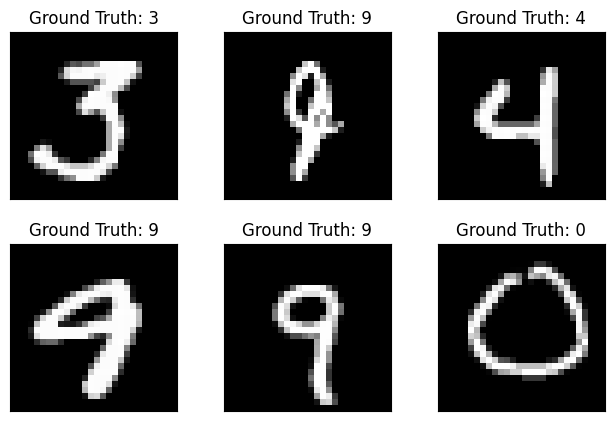

In [79]:
#@title Check the Dataset
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

Here is the model we will use. For now we are not logging it through Wandb.

In [80]:
#@title Network

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
model = Net().to('cuda:0')
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]


def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data=data.to('cuda:0')
    target = target.to('cuda:0')
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')


def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to('cuda:0')
      target = target.to('cuda:0')
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))



test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
  torch.save(model.state_dict(), f'./results/model_e{epoch}.pth')
  torch.save(optimizer.state_dict(), f'./results/optimizer_e{epoch}.pth')

/tmp/ipykernel_123109/835644703.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331797
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.303324
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.266475
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.272787
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.261453
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.231299
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.225890
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.222582
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.114448
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.042787
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.954830
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.993595
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.803929
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.503854
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.452519
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.505873
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.320353
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.361758
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.433705
Train Epoch: 1 [12160/6

Text(0, 0.5, 'negative log likelihood loss')

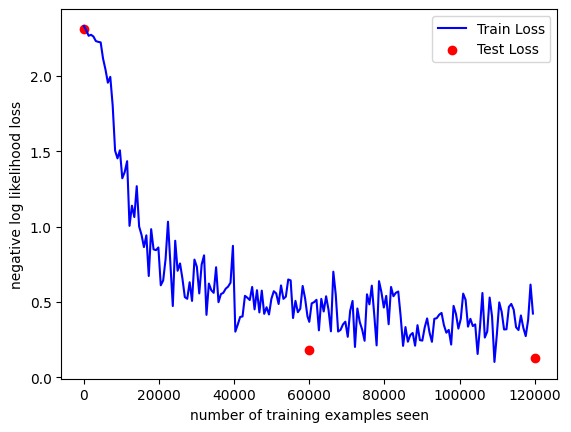

In [81]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

As seen bellow the results of the prediction is actually pretty good.

/tmp/ipykernel_123109/835644703.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


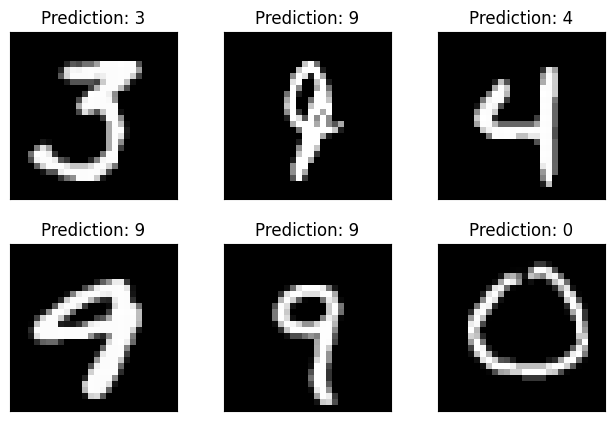

In [82]:
with torch.no_grad():
  output = model(example_data.to('cuda:0'))
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
  output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

Unitl now we didn't log any of the results. But, as said before, experimenting with more than a couple of models can be quite challenging. Now to use Wandb we must first login.

Two login we can either do it through the terminal or the code itself. The next cell contains the codes required for both of these models.

In [7]:
# For in terminal connection
#If logging in the main website
!Wandb login --relogin
# Also try --relogin in case of connection problems
!Wandb login --relogin --host=http://localhost:6060

# Import and login into your wandb account from wandb.ai
import wandb
#If logging in the main website
wandb.login(relogin=True)

# if logging locally
# wandb.login(relogin=True,host='http://localhost:6060')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/taha/.netrc


True

### Basic Wandb Features


First we need to define a configs dictionary. 

In [9]:
from types import MappingProxyType

config =    {
    'n_epochs' : 3,
    'batch_size_train' : 64,
    'batch_size_test' : 1000,
    'learning_rate' : 0.01,
    'momentum' : 0.5,
    'log_interval' : 10,
}

Then we can define a run which is all the results from a wandb init to a wandb finish

In [10]:
run = wandb.init(
    project="simple-cnn-project",
    notes="First Wss expriment",
    tags=["CNN", "mnist"],
    job_type='model',
    config=config
)

You can also display the wandb page in the jupyter file. The caviate is that it's only supported in colab

In [ ]:
#Display the whole workspace
# %%wandb
# # Display a project workspace
# %wandb USERNAME/PROJECT
# # Display a single run
# %wandb USERNAME/PROJECT/runs/RUN_ID
# # Display a sweep
# %wandb USERNAME/PROJECT/sweeps/SWEEP_ID
# # Display a report
# %wandb USERNAME/PROJECT/reports/REPORT_ID
# # Specify the height of embedded iframe
# %wandb USERNAME/PROJECT -h 2048

Anything printed during the run will be displayed in the logs for that run

In [11]:
print('This is a logged message')

This is a logged message


## Plotting

Here we have the code for plotting images and their prediction.

/tmp/ipykernel_123109/835644703.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


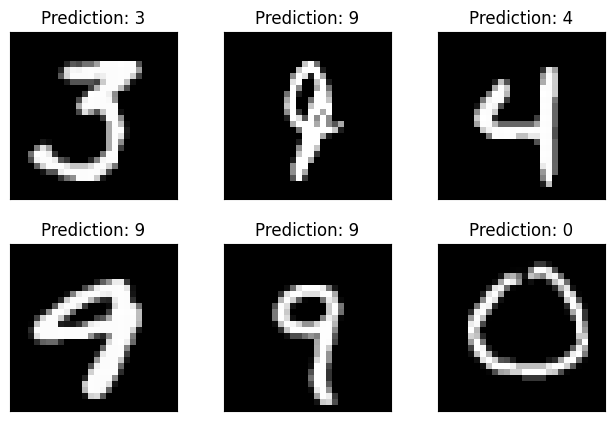

In [88]:
with torch.no_grad():
  output = model(example_data.to('cuda:0'))
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
  output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

A better way for logging this would be tables provided in wandb.

In [89]:
my_data=[]
for i in range(6):
    #Converting the numpy arrays to wandb images
    image = wandb.Image(example_data[i][0], caption=f"Prediction:{output.data.max(1, keepdim=True)[1][i].item()}")
    
    my_data.append([i,image,output.data.max(1, keepdim=True)[1][i].item()])
#defining the columns names in the table
columns = ["id", "image", "prediction"]
test_table = wandb.Table(data=my_data, columns=columns)
run.log({"test_table": test_table})

The best methode for logging is through metrics. To log a metric we will wandb.log(log_dict) where log_dict is a dictionary with keys as the name of the metrics and values as the value for each metric at the time of logging.  

In [90]:
#Metric Logging
import time

x_values=train_counter
y_values = train_losses
data = [[x, y] for (x, y) in zip(x_values, y_values)]
table = wandb.Table(data=data, columns=["x", "y"])
for i in range(len(data)):
  wandb.log(
      {
          "loss": y_values[i]

      }
  )


There are also functions used to plot lines directly which is not advised as functions provided in the Wandb UI is not applicable to them. 

In [91]:
#Unresumable
x_values = train_counter
y_values = train_losses
data = [[x, y] for (x, y) in zip(x_values, y_values)]
table = wandb.Table(data=data, columns=["x", "y"])
wandb.log(
    {
        "linear_plot": wandb.plot.line(
            table, "x", "y", title="Y vs X Linear Plot"
        )
    }
)

In [92]:

x_values = test_counter
y_values = test_losses
data = [[x, y] for (x, y) in zip(x_values, y_values)]
table = wandb.Table(data=data, columns=["x", "y"])
wandb.log(
    {
        "scatter_plot": wandb.plot.scatter(
            table, "x", "y", title="Y vs X Scatter Plot"
        )
    }
)

In [93]:
wandb.log(
    {
        "my_custom_id": wandb.plot.line_series(
            xs=[train_counter,test_counter],
            ys=[train_losses, test_losses],
            keys=["metric Y", "metric Z"],
            title="Two Random Metrics",
            xname="x units",
        )
    }
)


#log_code is used to create jobs but here our porpuse is to upload the codes availabe to the wandb run.
#Caution: For this to work it is neccessary to check "Enable code saving in your personal account".
run.log_code()

At the end wandb.finish() should be you used to end the run

In [95]:
wandb.finish()

A few more runs with different configs to chekc the comparison capabilities of wandb.

In [98]:

config =    {
    'n_epochs' : 2,
    'batch_size_train' : 256,
    'batch_size_test' : 1000,
    'learning_rate' : 0.01,
    'momentum' : 0.5,
    'log_interval' : 10,
}

run = wandb.init(
    project="simple-cnn-project",
    notes="First Wss expriment",
    tags=["CNN", "mnist"],
    job_type='model',
    name="Second Run",
    config=config
)


In [99]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=config.get('batch_size_train',64), shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
model = Net().to('cuda:0')
optimizer = optim.SGD(model.parameters(), lr=config.get('learning_rate',0.01),
                      momentum=momentum)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(config.get('n_epochs',3) + 1)]
time_step=0

def train(epoch):
  global time_step
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    time_step+=1
    data=data.to('cuda:0')
    target = target.to('cuda:0')
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')
      
      wandb.log({"loss": loss,"time_step":time_step})


def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to('cuda:0')
      target = target.to('cuda:0')
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))



test()
for epoch in range(1, config.get('n_epochs',3) + 1):
  train(epoch)
  test()
  
wandb.finish()

/tmp/ipykernel_123109/1931803584.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/taha/miniconda3/envs/HW/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323265
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.289978
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.282536
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.269886
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.240355
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.252689
Train Epoch: 1 [15360/60000 (26%)]	Loss: 2.206498
Train Epoch: 1 [17920/60000 (30%)]	Loss: 2.177895
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.118206
Train Epoch: 1 [23040/60000 (38%)]	Loss: 1.979553
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.926921
Train Epoch: 1 [28160/60000 (47%)]	Loss: 1.768897
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.613893
Train Epoch: 1 [33280/60000 (55%)]	Loss: 1.536416
Train Epoch: 1 [35840/60000 (60%)]	Loss: 1.433891
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.368635
Train Epoch: 1 [40960/60000 (68%)]	Loss: 1.305613
Train Epoch: 1 [43520/60000 (72%)]	Loss: 1.306385
Train Epoch: 1 [46080/60000 (77%)]	Loss: 1.140864
Trai

In [100]:
config =    {
    'n_epochs' : 2,
    'batch_size_train' : 32,
    'batch_size_test' : 1000,
    'learning_rate' : 0.0001,
    'momentum' : 0.5,
    'log_interval' : 10,
}

run = wandb.init(
    project="simple-cnn-project",
    notes="First Wss expriment",
    tags=["CNN", "mnist"],
    job_type='model',
    config=config
)

In [101]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=config.get('batch_size_train',64), shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
model = Net().to('cuda:0')
optimizer = optim.SGD(model.parameters(), lr=config.get('learning_rate',0.01),
                      momentum=momentum)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(config.get('n_epochs',3) + 1)]
time_step=0

def train(epoch):
  global time_step
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    time_step+=1
    data=data.to('cuda:0')
    target = target.to('cuda:0')
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')
      wandb.log({"loss": loss,"time_step":time_step})


def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to('cuda:0')
      target = target.to('cuda:0')
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))



test()
for epoch in range(1, config.get('n_epochs',3) + 1):
  train(epoch)
  test()
  
wandb.finish()

/tmp/ipykernel_123109/1931803584.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306625
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.321908
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.344311
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.300329
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.297053
Train Epoch: 1 [1600/60000 (3%)]	Loss: 2.310789
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.314709
Train Epoch: 1 [2240/60000 (4%)]	Loss: 2.320840
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.316985
Train Epoch: 1 [2880/60000 (5%)]	Loss: 2.294998
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.353166
Train Epoch: 1 [3520/60000 (6%)]	Loss: 2.341589
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.298612
Train Epoch: 1 [4160/60000 (7%)]	Loss: 2.333501
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.296908
Train Epoch: 1 [4800/60000 (8%)]	Loss: 2.315851
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.367093
Train Epoch: 1 [5440/60000 (9%)]	Loss: 2.316557
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.366895
Train Epoch: 1 [6080/60000 (10%)]	Los

## Runs retrival and changing

Here you can see a few capabilities of Wandb in retriving and changing the runs already finished. 

In [12]:
import wandb
api = wandb.Api()

In [34]:
#It is possible to create projects or runs from the API
api.create_project(name='new_project',entity='teimuri')
run = api.create_run(project='new_project',entity='teimuri')

In [48]:
#It is also possible to access the name of the projects
for project in api.projects():
    print(project.name)

new_project
lineage-example
report-api-quickstart
simple-cnn-project
fmnist_job_tutorial
job-creation-demo
model-registry


In [49]:
#Or access an specific run object
project_name = 'simple-cnn-project'
project = api.project(project_name)


In [13]:
#Also by having the name of desired project it's possible to get the name and id of the runs in that project.
for run in api.runs('simple-cnn-project'):
    print(f'The name of the run is {run.name} and id of the run is {run.id}')


The name of the run is cerulean-firefly-5 and id of the run is 8yg78e1b
The name of the run is super-sound-4 and id of the run is hf4rm9yp
The name of the run is eternal-microwave-3 and id of the run is fy7agpla
The name of the run is fluent-wave-2 and id of the run is rn583ya3
The name of the run is revived-mountain-1 and id of the run is 8ndlxe2k


In [14]:
#Run id is specially important as it is used to access the run object.
#Accessing the run is in particular important as it is used to access the artifacts, logs, and other information of the run.
run_id='8yg78e1b'
run =api.run(f'teimuri/simple-cnn-project/{run_id}')
run.name

'cerulean-firefly-5'

wandb: Network error (ConnectionError), entering retry loop.


In [64]:
# As an example, Here we are accessing a run and downloading the files from it.
#These files can be any data logged into wandb.
Files = run.files()
for file in Files:
    file.download(root='downloaded_file')
    

In [ ]:
#It is also possible to update the config after ward
#one at a time
run.config['batch_size'] = {"batch_size": 128}
#Or multiples at the same time
run.config.update({"pool_sizes": [2],"dropout": 0.5})

In [ ]:
run.name='early-workshop-test-1'

New Text


In [16]:
#Incase cnages are made to the code it is necessary to use run.update()
run.update()

In [ ]:
#Using wandb.run by itself will probide to us the latest run.
username = wandb.run.entity
project = wandb.run.project
run_id = wandb.run.id

run = api.run(f"{username}/{project}/{run_id}")
run.config["bar"] = 32
run.update()